# Prepare the Notebook

In [1]:
!pip install control
!git clone https://magiccvs.byu.edu/gitlab/whirlybird/control_book_public_solutions.git
    !cd control_book_public_solutions/;  git checkout Fall19_edits

I want the Fall19_edits branch. If you want a different branch, put that branch name in place of 'Fall19_edits' and re-run the cell. If you want the Master branch, just comment out that line.

In [4]:
!cd control_book_public_solutions/;  git pull

Already up to date.


In [0]:
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.display import Image

In [0]:
# Insert figures:
#basename = 'control_book_public_solutions/_images/'
#basename = './'
#img1 = Image(filename=basename+'figures_3/pid_complex_poles.png',width=1000)

# Part 3: PID Control Design
## Chapter 10: Digital Implmentation of PID  Controllers

### Lecture Notes

This notebook covers the material in Chapter 10 of the [text](http://controlbook.byu.edu/doku.php) in brief form, allowing you to make changes and manipulate the examples.  The goal is for this resource to help you bridge the gap between theory and the practical.

## Sample Time Summary
The text covers the derivation for discrete time approximations to the continuous time PID terms derived in earlier chapters.  Here we will just summarize these and then implement them.

### Proportional
This one is easy: $u_P[n] = k_p e[n]$, for sample time $n$, where $e[n]$ is the error at sample time $n$. 

### Integral
Using the inverse z-transform of the Tustin approximation of the simple $\frac{1}{s}$ Laplace term, we have: 
$u_I[n] = u_I[n-1] + \frac{T_s}{2}(e[n] + e[n-1])$, where $T_s$ is the sample time period (in seconds)

### Derivative
We utilize a dirty derivative term, that allows for a band-limited ($\frac{1}{\sigma}$ bandwidth) derivative of a signal
$u_D[n] = \frac{2 \sigma - T_s}{2 \sigma + T_s} u_D[n-1] + \frac{2}{2 \sigma + T_s} (e[n] - e[n-1])$

OR

$u_D[n] = \frac{2 \sigma - T_s}{2 \sigma + T_s} u_D[n-1] + \frac{2}{2 \sigma + T_s} (y[n] - y[n-1])$

## PID
The combined PID control effort is then 
$u[n] = k_P u_p[n] + k_D u_D[n] + k_I u_I[n]$
 

In [0]:
#TODO: Turn the cell below into an interactive example, where students are given the shell and have to input the code \
# to make it work!  
# Then, use this control class in the simulation below! Bring in code from Ch7 & 8 to define the gains right - making it a 
# fully interactive example of what to do.  

Below is an example of a PID controller class in Python: 

```
import numpy as np

class PIDControl:
    def __init__(self, kp, ki, kd, limit, sigma, intlimit, Ts):
        self.kp = kp                 # Proportional control gain
        self.ki = ki                 # Integral control gain
        self.kd = kd                 # Derivative control gain
        self.limit = limit           # The output will saturate at this limit
        self.sigma = sigma           # gain for dirty derivative
        self.intlimit = intlimit     # anti-integrator windup - derivative must be below to integrate
        self.Ts = Ts                 # sample rate

        self.y_dot = 0.0             # estimated derivative of y
        self.y_d1 = 0.0              # Signal y delayed by one sample
        self.error_dot = 0.0         # estimated derivative of error
        self.error_d1 = 0.0          # Error delayed by one sample
        self.integrator = 0.0        # integrator

    def PID(self, y_r, y, flag=True):
        '''
            PID control,

            if flag==True, then returns
                u = kp*error + ki*integral(error) + kd*error_dot.
            else returns 
                u = kp*error + ki*integral(error) - kd*y_dot.

            error_dot and y_dot are computed numerically using a dirty derivative
            integral(error) is computed numerically using trapezoidal approximation
        '''

        # Compute the current error
        error = y_r - y
        
        # Differentiate error and y: 
        differentiate(error, y)
        
        # integrate error if derivative is small
        if self.y_dot > self.intlimit:
            self.integrator = self.integrator + (self.Ts/2)*(error+self.error_d1)

        # PID Control
        if flag is True:
            # D control with error_dot
            u_unsat = self.kp*error + self.ki*self.integrator + self.kd*self.error_dot
        else:
            # D control with y_dot
            u_unsat = self.kp*error + self.ki*self.integrator - self.kd*self.y_dot
            
        # return saturated control signal
        u_sat = self.saturate(u_unsat)
        
        # integrator anti - windup
        if self.ki != 0.0:
            self.integrator = self.integrator + self.Ts / self.ki * (u_sat - u_unsat)
            
        # update delayed variables
        self.error_d1 = error
        self.y_d1 = y
        return u_sat

    def PD(self, y_r, y, flag=True):
        '''
            PD control,
            
            if flag==True, then returns
                u = kp*error + kd*error_dot.
            else returns 
                u = kp*error - kd*y_dot.
            
            error_dot and y_dot are computed numerically using a dirty derivative
        '''

        # Compute the current error
        error = y_r - y

        # Differentiate error and y: 
        differentiate(error, y)
        
        # PD Control
        if flag is True:
            # PD control w/ error_dot
            u_unsat = self.kp*error + self.kd*self.error_dot
        else:
            # PD control w/ y_dot
            u_unsat = self.kp*error - self.kd*self.y_dot
        
        # return saturated control signal
        u_sat = self.saturate(u_unsat)
        
        # update delayed variables
        self.error_d1 = error
        self.y_d1 = y
        return u_sat
        
        
    def differentiate(self, error, y)
        # differentiate y
        self.y_dot = (2.*self.sigma - self.Ts)/(2.*self.sigma + self.Ts) * self.y_dot + 2./(2.*self.sigma + self.Ts) * (y - self.y_d1)
        
        # differentiate error
        self.error_dot = (2.*self.sigma - self.Ts)/(2.*self.sigma + self.Ts) * self.error_dot + 2./(2.*self.sigma + self.Ts) * (error - self.error_d1)
        return
            
           
    def saturate(self,u):
        if abs(u) > self.limit:
            u = self.limit*np.sign(u)
        return u

        
```        

## Integrator Anit-windup
One potential problem, that can cause big issues in practice, is the concept of integrator windup.  When the error is large and it persists for a long time, the $u_I$ term can become very large, i.e. "wind up".  This can then case large control efforts in the direction to correct the error, which will often dramatically overshoot and destabalize the system.
The key in implementation is to add a scheme to guard against wind-up. We summarize two schemes here: 

### Sum Steady-state Only
In this scheme, the idea is to only allow the integrator to sum when the derivative term is low, under some threshold $\bar{v}$; meaning the system is likely in steady state and not in the transient porition of it's response. It would look something like this: 

`if np.abs(differentiator) < vbar
    integrator = integrator + (Ts/2.)*(error + error_old)
`

### Saturation Bound Output
This scheme seeks to subtract from the integrator term the exact amount needed to keep the output $u$ from saturating.  The implementation would look something like this: 

Compute the unsaturated outputs
$$ u_{\text{unsat}} = k_P e[n] + k_D u_D[n] + k_I u_I[n].$$
Then saturate the output
$$ u[n] = \text{sat}(u_{\text{unsat}}), $$
but before the function completes and the saturated control signal is sent to the actuators, we rewrite $u_I[n]$ as
$$ u_I[n] = u_I[n] + \frac{1}{k_I}(u - u_{\text{unsat}}), $$
which is the updated value of the integrator that ensures that the control signal remains just out of saturation (assuming that $k_I \neq 0$).  Note that if the control value is not in saturation then $u=u_{\text{unsat}}$ and the integrator value remains unchanged.  This scheme is demonstarted in the sample PID control code above. 


## Gain Selection for PID
Gain selection for PID control usually proceeds in the following manner.  
 * The proportional and derivative gains $k_P$ and $k_D$ are first selected according to the methods discussed in Chapter 8.  
 * The integral gain $k_I$ is then tuned by starting with zero and then slowly increasing the gain until the steady state error is removed.  The parameters associated with the anti-windup scheme, especially $\bar{v}$, are also adjusted during this phase.  
 * The proportional and derivative gains can then be adjusted if necessary by re-tuning $\omega_n$ and $\zeta$.  
 * In the case of successive loop closure, **integrators are only added on the outer loop.**

The addition of an integrator has a destabilizing effect on the feedback system.  This effect is most easily understood by using the root locus method described in Appendix E, where it can be seen that for second order systems, a large $k_I$ will always result in closed loop poles in the right half plane.  The root locus can also be used to aid in the selection of the integral gain $k_I$, where the value of $k_I$ is selected so that integrator has minimal impact on the closed loop poles designed using PD control.  A more effective method for selecting integral gains will be discussed in Chapter 12.

# Examples: Design Study A. Single Link Robot Arm
> (a)  Modify the system dynamics file so that the parameters vary by up to 20\% each time they are run (uncertainty parameter = 0.2).

> (b)  Rearrange the block diagram so that the controller is implemented as an m-function implemented at the sample rate of $T_s=0.01$.  The controller should only assume knowledge of the angle $\theta$ and the reference angle $\theta_r$.

> (c)  Implement the PID controller designed in Problems A.8 using an m-function called arm\_ctrl.m.   Use the dirty derivative gain of $\tau=0.05$.  Tune the integrator to remove the steady state error caused by the uncertain parameters.

## A - (a) Vary the dynamic parameters of the simulation by 20%

Here is an extract of the armDynamics.py code: 
```
#The parameters for any physical system are never known exactly.  Feedback
#systems need to be designed to be robust to this uncertainty.  In the simulation
#we model uncertainty by changing the physical parameters by a uniform random variable
#that represents alpha*100 % of the parameter, i.e., alpha = 0.2, means that the parameter
#may change by up to 20%.  A different parameter value is chosen every time the simulation
#is run.
alpha = 0.2  # Uncertainty parameter
self.m = P.m * (1+2*alpha*np.random.rand()-alpha)  # Mass of the arm, kg
self.ell = P.ell * (1+2*alpha*np.random.rand()-alpha)  # Length of the arm, m
self.b = P.b * (1+2*alpha*np.random.rand()-alpha)  # Damping coefficient, Ns
self.g = P.g  # the gravity constant is well known and so we don't change it.
self.Ts = P.Ts  # sample rate at which the dynamics are propagated - do not vary this. 
```

## A - (b) Implement the controller at sample rate of $T_s$
For python, I am already running the simulation at the sample rate of $T_s$. But in Simulink, you double-click the block for the control, and set the sample rate parameter to P.Ts

## A - (c) Simulate with PID Control
Using the PID controller code outlined above, and the parameter variations from part A, we can demonstrate our improved control (elimination of steady-state error) in simulation: 

In [8]:
!cd control_book_public_solutions/_a_arm/python/hw_a/; ls

armAnimation.py  armSim.py  dataPlotter.py  __pycache__  signalGenerator.py


In [9]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_a_arm/python/')
sys.path.append('control_book_public_solutions/_a_arm/python/hw10/')  # add homework directory
import armParam as P
from hw_b.armDynamics import armDynamics
from hw10.armController import armController
from hw_a.signalGenerator import signalGenerator
from hw_a.armAnimation import armAnimation
from hw_a.dataPlotter import dataPlotter as armPlotData

kp:  0.45374999999999993
ki:  0.1
kd:  0.06665499999999998


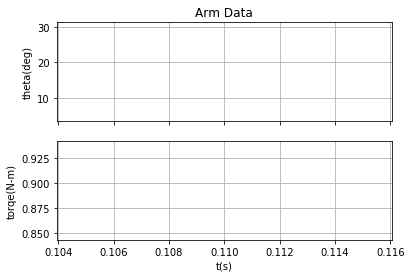

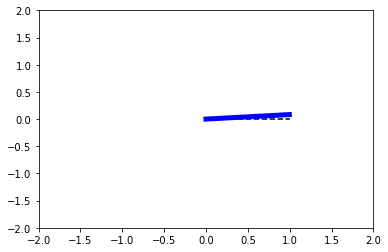

In [11]:
# instantiate arm, controller, and reference classes
arm = armDynamics()
ctrl = armController()
reference = signalGenerator(amplitude=30*np.pi/180.0, frequency=0.05)

# instantiate the simulation plots and animation
armDataPlot = armPlotData()
animation = armAnimation()

# set disturbance input
disturbance = 0.01

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.update(ref_input, arm.state)  # Calculate the control value
        sys_input = u + disturbance
        arm.update(sys_input)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(arm.state)
    armDataPlot.update(t, ref_input, arm.state, u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlot(dataPlot_arm):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=2, ncols=1)
  fig.tight_layout()
  plt.subplot(211)  
  plt.plot(dataPlot_arm.time_history, np.transpose([dataPlot_arm.theta_history, dataPlot_arm.theta_ref_history]))
  plt.title('Arm Data' )
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(212)
  plt.plot(dataPlot_arm.time_history, dataPlot_arm.torque_history)
  plt.ylabel('Torque (N-m)')
  plt.xlabel('time (s)')

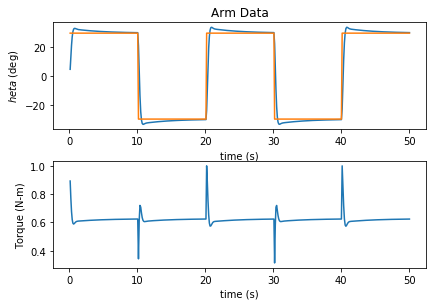

In [13]:
postProcessPlot(armDataPlot)

# Examples - Design Study B: Inverted Pendulum
> (a)  Modify the system dynamics file so that the parameters $m_1$, $m_2$, $\ell$ and $b$ vary by up to 20\% of their nominal value each time they are run (uncertainty parameter = 0.2).

> (b)  Rearrange the block diagram so that the controller is implemented as an m-function implemented at the sample rate of $T_s=0.01$.  The controller should only assume knowledge of the position $z$ and the angle $\theta$, as well as the reference position $z_r$.

> (e)  Implement the nested PID loops designed in Problems B.8 using an m-function called pendulum\_ctrl.m.   Use the dirty derivative gain of $\tau=0.05$. Tune the integrator to remove the steady state error caused by the uncertain parameters.

## B - (a) Vary Dynamic Parameters
The section of code in python to vary the dynamic parameters: 
```
# The parameters for any physical system are never known exactly.  Feedback
# systems need to be designed to be robust to this uncertainty.  In the simulation
# we model uncertainty by changing the physical parameters by a uniform random variable
# that represents alpha*100 % of the parameter, i.e., alpha = 0.2, means that the parameter
# may change by up to 20%.  A different parameter value is chosen every time the simulation
# is run.
alpha = 0.2  # Uncertainty parameter
self.m1 = P.m1 * (1+2*alpha*np.random.rand()-alpha)  # Mass of the pendulum, kg
self.m2 = P.m2 * (1+2*alpha*np.random.rand()-alpha)  # Mass of the cart, kg
self.ell = P.ell * (1+2*alpha*np.random.rand()-alpha)  # Length of the rod, m
self.b = P.b * (1+2*alpha*np.random.rand()-alpha)  # Damping coefficient, Ns
self.g = P.g  # the gravity constant is well known and so we don't change it.
```

## B - (b) Sample Control at $T_s$
See comment for A - (b) above

## B - (c) Simulate PID Control

In [0]:
# Design Problem B : Pendulum
sys.path.remove('control_book_public_solutions/_a_arm/python/')
sys.path.remove('control_book_public_solutions/_a_arm/python/hw10/')

DC_gain 1.8754253767622748
kp_th:  -26.24319727891157
kd_th:  -3.1478333333333333
kp_z:  -0.06189092517559949
ki_z:  0.0001
kd_z:  -0.1506408552390715


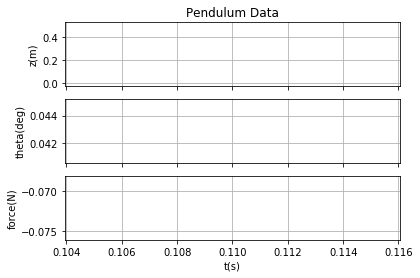

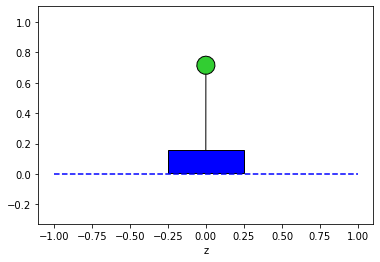

In [2]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_B_pendulum/python')
sys.path.append('control_book_public_solutions/_B_pendulum/python/hw10/')  # add homework directory
import pendulumParam as P
from hw_b.pendulumDynamics import pendulumDynamics
from hw10.pendulumController import pendulumController
from hw_a.signalGenerator import signalGenerator
from hw_a.pendulumAnimation import pendulumAnimation
from hw_a.dataPlotter import dataPlotter as pendulumPlotData

pendulum = pendulumDynamics()
ctrl = pendulumController() # put in the gains we computed above for the inner loop. 
reference = signalGenerator(amplitude=0.5, frequency=0.02)

# instantiate the simulation plots and animation
pendDataPlot = pendulumPlotData()
animation = pendulumAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.update(ref_input, pendulum.state)  # Calculate the control value        
        pendulum.update(u)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(pendulum.state)
    pendDataPlot.update(t, ref_input, pendulum.state, u)
    #dataPlot.update(t, [0.0,0.0], pendulum.state, u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlotPendulum(dataPlot_pen):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=3, ncols=1)
  fig.tight_layout()
  plt.subplot(311)  
  plt.plot(dataPlot_pen.time_history, np.transpose([dataPlot_pen.z_history, dataPlot_pen.zref_history]))
  plt.title('Pendulum Data' )
  plt.ylabel('$z$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(312)  
  plt.plot(dataPlot_pen.time_history, np.transpose(dataPlot_pen.theta_history))
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(313)
  plt.plot(dataPlot_pen.time_history, dataPlot_pen.Force_history)
  plt.ylabel('Force (N)')
  plt.xlabel('time (s)')

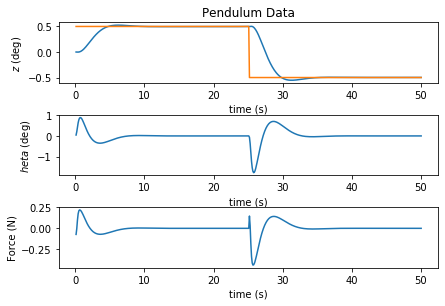

In [4]:
postProcessPlotPendulum(pendDataPlot)

# Examples - Design Study C: Satellite Control
> (a)  Modify the system dynamics file so that the parameters $J_s$, $J_p$, $k$ and $b$ vary by up to 20\% of their nominal value each time they are run (uncertainty parameter = 0.2).

>(b)  Rearrange the block diagram so that the controller is implemented as an m-function implemented at the sample rate of $T_s=0.01$.  Assume that the controller only has knowledge of the angles $\phi$ and $\theta$ as well as the reference angle $\phi_r$.

>(c)  Implement the nested PID loops designed in Problems C.8 using an m-function called satellite\_ctrl.m.   Use the dirty derivative gain of $\tau=0.05$. Tune the integrator to remove the steady state error caused by the uncertain parameters.

## C - (a) Vary Dynamic Parameters
Here is code demonstrating varying the dynamic parameters: 
```
# The parameters for any physical system are never known exactly.  Feedback
# systems need to be designed to be robust to this uncertainty.  In the simulation
# we model uncertainty by changing the physical parameters by a uniform random variable
# that represents alpha*100 % of the parameter, i.e., alpha = 0.2, means that the parameter
# may change by up to 20%.  A different parameter value is chosen every time the simulation
# is run.
alpha = 0.2  # Uncertainty parameter
self.Js = P.Js * (1+2*alpha*np.random.rand()-alpha)  # inertia of base
self.Jp = P.Jp * (1+2*alpha*np.random.rand()-alpha)  # inertia of panel
self.k = P.k * (1+2*alpha*np.random.rand()-alpha)    # spring coefficient
self.b = P.b * (1+2*alpha*np.random.rand()-alpha)    # Damping coefficient, Ns

```

## C - (b) Sample Control at $T_s$
See part A - (b) above

## C - (c) Simulate PID
Here is the simulation of our PID controller, see the ability of the control to take out state state error. 

In [0]:
# Design Problem B : Pendulum
sys.path.remove('control_book_public_solutions/_B_pendulum/python')
sys.path.remove('control_book_public_solutions/_B_pendulum/python/hw10/')

k_DC_phi 0.3781272785378374
kp_th:  49.23775510204083
kd_th:  22.169999999999998
kp_phi:  0.6098984704403007
kd_phi:  2.8573062567076946


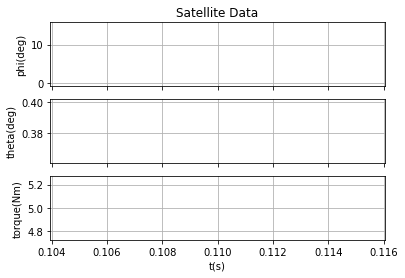

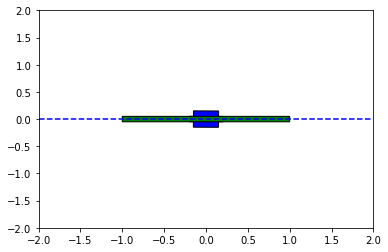

In [3]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_C_satellite/python/')
sys.path.append('control_book_public_solutions/_C_satellite/python/hw10')
import satelliteParam as P
from hw_b.satelliteDynamics import satelliteDynamics
from hw10.satelliteController import satelliteController
from hw_a.signalGenerator import signalGenerator
from hw_a.satelliteAnimation import satelliteAnimation
from hw_a.dataPlotter import dataPlotter as satellitePlotData
P.k = 0.1

# instantiate satellite, controller, and reference classes
satellite = satelliteDynamics()
ctrl = satelliteController()
reference = signalGenerator(amplitude=15.0*np.pi/180.0, frequency=0.02)

# set disturbance input
disturbance = 0.50

# instantiate the simulation plots and animation
satDataPlot = satellitePlotData()
animation = satelliteAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot:  # updates control and dynamics at faster simulation rate
        tau = ctrl.update(ref_input, satellite.state)  # Calculate the control value
        sys_input = tau+disturbance  # input to plant is control input + disturbance (formatted as a list)
        satellite.update(sys_input)  # Propagate the dynamics with disturbance input
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(satellite.state)
    satDataPlot.update(t, ref_input, satellite.state, tau)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlotSatellite(dataPlot_sat):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=3, ncols=1)
  fig.tight_layout()
  plt.subplot(311)  
  plt.plot(dataPlot_sat.time_history, np.transpose([dataPlot_sat.phi_history, dataPlot_sat.phi_ref_history]))
  plt.title('Satellite Data' )
  plt.ylabel('$\phi$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(312)  
  plt.plot(dataPlot_sat.time_history, np.transpose(dataPlot_sat.theta_history))
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(313)
  plt.plot(dataPlot_sat.time_history, dataPlot_sat.torque_history)
  plt.ylabel('Torque (Nm)')
  plt.xlabel('time (s)')

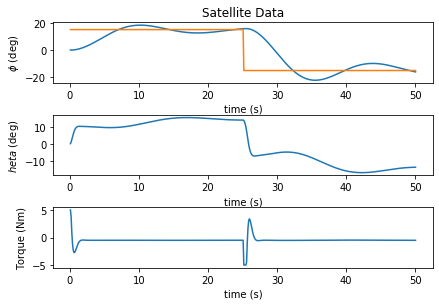

In [7]:
postProcessPlotSatellite(satDataPlot)